In [81]:
import math
from ast import literal_eval

import plotly.express as px
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.parametrize as parametrize
from matrepr import mdisplay
from plotly.subplots import make_subplots
from safetensors.torch import load_file, load_model
from torch import linalg
from torch.nn.utils.parametrizations import orthogonal
from torch.utils.data import DataLoader, Dataset
from torcheval.metrics import MulticlassAccuracy

from koopmann import aesthetics
from koopmann.data import (
    DatasetConfig,
    create_data_loader,
    get_dataset_class,
)
from koopmann.models import MLP, Autoencoder, ExponentialKoopmanAutencoder
from koopmann.models.utils import (
    get_device,
    pad_act,
    parse_safetensors_metadata,
)

# from koopmann.utils import compute_model_accuracy
from koopmann.visualization import plot_eigenvalues

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
model_name = "mnist_probed"
ae_name = "mnist_model"
scale_idx = "0"
k = "1"
dim = "1024"
user = "nsa325"

In [83]:
# Original model path
model_file_path = f"/scratch/{user}/koopmann_model_saves/{model_name}.safetensors"

# Autoenoder path in work dir
ae_file_path = f"/scratch/{user}/koopmann_model_saves/scaling/k_{k}_dim_{dim}_loc_{scale_idx}_autoencoder_{ae_name}.safetensors"

In [84]:
model, _ = MLP.load_model(model_file_path)
model.modules[-2].remove_nonlinearity()
# model.modules[-3].update_nonlinearity("leakyrelu")
model.modules[-3].remove_nonlinearity()
model.eval()
model.hook_model()

In [85]:
metadata = parse_safetensors_metadata(file_path=model_file_path)
dataset_config = DatasetConfig(
    dataset_name=metadata["dataset"],
    num_samples=5_000,
    split="test",
    seed=21,
)
DatasetClass = get_dataset_class(name=dataset_config.dataset_name)
dataset = DatasetClass(config=dataset_config)
dataloader = create_data_loader(dataset, batch_size=1024)

In [86]:
# Parse metadata
metadata = parse_safetensors_metadata(file_path=ae_file_path)

# Load base model
autoencoder = Autoencoder(
    input_dimension=literal_eval(metadata["input_dimension"]),
    latent_dimension=literal_eval(metadata["latent_dimension"]),
    nonlinearity=metadata["nonlinearity"],
    k=literal_eval(metadata["steps"]),
    batchnorm=literal_eval(metadata["batchnorm"]),
    hidden_configuration=literal_eval(metadata["hidden_configuration"]),
)

# Load weights
load_model(autoencoder, ae_file_path, device="cpu", strict=True)
autoencoder.eval()

k = literal_eval(metadata["num_scaled"])
print(f"Little K: {k}")

Little K: 1


In [87]:
K_matrix = autoencoder.koopman_matrix.linear_layer.weight.T.detach()

In [88]:
images, labels = next(iter(dataloader))

In [89]:
with torch.no_grad():
    x = images.flatten(start_dim=1)
    x_obs = autoencoder._encode(x)
    pred_obs = x_obs @ K_matrix
    x_recon = autoencoder._decode(x_obs)
    x_pred = autoencoder._decode(pred_obs)

In [90]:
sample_idx = torch.randint(1024, (1,))[0].item()
fig = make_subplots(rows=1, cols=2, subplot_titles=["Original", "Reconstructed"])

for i, img in enumerate([x[sample_idx], x_recon[sample_idx]], 1):
    fig.add_trace(px.imshow(img.reshape(28, 28)).data[0], row=1, col=i)

fig.update_layout(height=400, width=800, xaxis_scaleanchor="y", xaxis2_scaleanchor="y2")
fig.show()

print(f"Error: {F.mse_loss(x[sample_idx], x_recon[sample_idx], reduction='sum')}")

Error: 30.95379638671875


In [91]:
with torch.no_grad():
    x = images.flatten(start_dim=1)
    _ = model(x)
    act_dict = model.get_fwd_activations()
    probe_act = act_dict[4]
    act_obs = autoencoder._encode(probe_act)
    probe_recon = autoencoder._decode(act_obs)

In [92]:
fig = make_subplots(rows=1, cols=2, subplot_titles=["Original", "Reconstructed"])

for i, img in enumerate([probe_act[sample_idx], probe_recon[sample_idx]], 1):
    fig.add_trace(px.imshow(img.reshape(28, 28)).data[0], row=1, col=i)

fig.update_layout(height=400, width=800, xaxis_scaleanchor="y", xaxis2_scaleanchor="y2")
fig.show()
print(
    f"Reconstruction Error: {F.mse_loss(probe_act[sample_idx], probe_recon[sample_idx], reduction='sum')}"
)

Reconstruction Error: 0.1255495846271515


In [93]:
fig = make_subplots(rows=1, cols=2, subplot_titles=["Observable", "Predicted Observable"])

for i, img in enumerate([act_obs[sample_idx], pred_obs[sample_idx]], 1):
    fig.add_trace(
        px.imshow(img.reshape(32, 32)).data[0],
        row=1,
        col=i,
    )

fig.update_layout(height=400, width=800, xaxis_scaleanchor="y", xaxis2_scaleanchor="y2")
fig.show()
print(
    f"Linear Prediction Error: {F.mse_loss(pred_obs[sample_idx], act_obs[sample_idx], reduction='sum')}"
)

Linear Prediction Error: 0.0869823470711708


In [94]:
fig = make_subplots(rows=1, cols=2, subplot_titles=["Original", "Predicted"])

for i, img in enumerate([probe_act[sample_idx], x_pred[sample_idx]], 1):
    fig.add_trace(px.imshow(img.reshape(28, 28)).data[0], row=1, col=i)

fig.update_layout(height=400, width=800, xaxis_scaleanchor="y", xaxis2_scaleanchor="y2")
fig.show()
print(f"Error: {F.mse_loss(probe_act[sample_idx], x_pred[sample_idx], reduction='sum')}")

Error: 14.117976188659668


In [95]:
def compute_model_accuracy(model, dataset, batch_size=1_024):
    model.eval()
    model.hook_model()
    dataloader = DataLoader(dataset, batch_size=batch_size)

    metric_original = MulticlassAccuracy()
    metric_altered = MulticlassAccuracy()

    device = get_device()

    for batch in dataloader:
        input, target = batch
        input, target = input.to(device), target.to(device)
        output_original = model(input)

        pred_act = autoencoder(input.flatten(start_dim=1), k=1).predictions[-1]
        output_altered = model.modules[-2:](pred_act)

        metric_original.update(output_original, target.squeeze())
        metric_altered.update(output_altered, target.squeeze())
    return metric_original.compute(), metric_altered.compute()


acc_orig, acc_ae = compute_model_accuracy(model.to("cpu"), dataset)
print(f"Original Model Testing Accuracy: {acc_orig}")
print(f"Autoencoder Prediction Testing Accuracy: {acc_ae}")

Original Model Testing Accuracy: 0.9771000146865845
Autoencoder Prediction Testing Accuracy: 0.9758999943733215


(<Figure size 400x400 with 1 Axes>,
 array([<Axes: title={'center': '$k=0$, $dim=0$'}>], dtype=object))

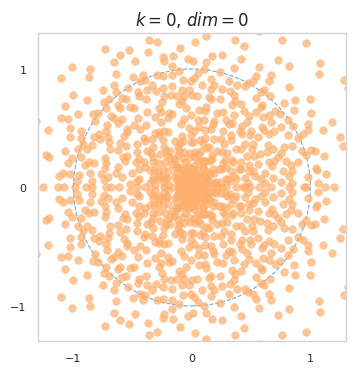

In [96]:
eigenvalues, eigenvectors = torch.linalg.eig(K_matrix)
plot_eigenvalues({(0, 0): eigenvalues})